In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import io

from keras.preprocessing.sequence import pad_sequences

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report

import torch
from torch.utils.data import DataLoader, TensorDataset, RandomSampler, SequentialSampler
from torch.optim.lr_scheduler import ExponentialLR

from tqdm import tqdm, trange

import warnings
warnings.filterwarnings("ignore")

Metaverse Financial Transactions Dataset
https://www.kaggle.com/datasets/faizaniftikharjanjua/metaverse-financial-transactions-dataset

In [2]:
# 云端数据
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
'''
# 划分小数据集测试
df = pd.read_csv('/content/drive/MyDrive/data/MetaverseFinancialTX/metaverse.csv')
# 随机抽取10%的数据
df_sample = df.sample(frac=0.1, random_state=1)
# 将抽取的数据保存为新的CSV文件
df_sample.to_csv('/content/drive/MyDrive/data/MetaverseFinancialTX/small_metaverse.csv', index=False)
'''

"\n# 划分小数据集测试\ndf = pd.read_csv('/content/drive/MyDrive/data/MetaverseFinancialTX/metaverse.csv')\n# 随机抽取10%的数据\ndf_sample = df.sample(frac=0.1, random_state=1)\n# 将抽取的数据保存为新的CSV文件\ndf_sample.to_csv('/content/drive/MyDrive/data/MetaverseFinancialTX/small_metaverse.csv', index=False)\n"

Naive Bayes

In [4]:
# 读取数据
data = pd.read_csv('/content/drive/MyDrive/data/MetaverseFinancialTX/metaverse.csv')
data.shape

(78600, 14)

*   transaction_type有5种:  phishing、purchase、sale、scam、transfer
*   location_region有5种: Africa、Asia、Europe、North America、South America
*   age_group有3种: established、new、veteran
*   purchase_pattern有3种：focused、high_value、random
*   ip_prefix有5种：10、172、172.16、192、192.168

In [5]:
# 对类别型特征'transaction_type', 'location_region', 'age_group'做编码
# LabelEncoder可以将类别转换为0到n-1之间的数,n是类别的数量
cols = ['transaction_type', 'location_region', 'age_group']
le = LabelEncoder()
for col in cols:
    data[col] = le.fit_transform(data[col])

# 对数值型特征'hour_of_day', 'amount', 'login_frequency', 'session_duration', 'risk_score'做标准化
# StandardScaler可以将特征标准化,使其均值为0,方差为1
num_cols = ['hour_of_day', 'amount', 'login_frequency', 'session_duration', 'risk_score']
ss = StandardScaler()
data[num_cols] = ss.fit_transform(data[num_cols])

# 将数据划分为训练集和测试集
# X是特征矩阵,y是标签,'anomaly'列是我们要预测的标签
# 这里删除了一些不需要的列如时间戳、地址等
X = data.drop(['timestamp', 'sending_address', 'receiving_address', 'ip_prefix', 'purchase_pattern', 'anomaly'], axis=1)
y = data['anomaly']
# 按8:2的比例划分训练集和测试集,random_state是随机数种子,确保每次运行得到相同的划分结果
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 创建并训练一个高斯朴素贝叶斯分类器
# GaussianNB假设每个类别的每个特征都服从高斯分布
gnb = GaussianNB()
# 用训练集数据拟合(fit)模型,根据每个特征的均值和方差来估计高斯分布的参数
gnb.fit(X_train, y_train)

# 在测试集上做预测,y_pred是预测的anomaly标签
y_pred = gnb.predict(X_test)
# 评估模型性能,打印precision, recall, f1-score等指标
print(classification_report(y_test, y_pred))

               precision    recall  f1-score   support

    high_risk       1.00      1.00      1.00      1251
     low_risk       0.99      0.83      0.91     12848
moderate_risk       0.42      0.95      0.58      1621

     accuracy                           0.86     15720
    macro avg       0.80      0.93      0.83     15720
 weighted avg       0.93      0.86      0.88     15720



*   precision: 精确率,表示在模型预测为某个类别的样本中,真正属于该类别的比例
*   recall: 召回率,表示在真正属于某个类别的样本中,被模型正确预测的比例
*   f1-score: 精确率和召回率的调和平均数,F1分数越高说明模型在该类别上的性能越好。
*   support: 支持度,表示测试集中每个类别的真实样本数量。
*   accuracy: 准确率,表示在所有样本中,被正确分类的比例
*   macro avg: 宏平均,计算每个类别的指标的算术平均数,不考虑类别的样本数量差异。
*   weighted avg: 加权平均,计算每个类别的指标的加权平均数,权重为每个类别的样本数量。

In [6]:
from sklearn.metrics import classification_report

# 在训练集上做预测
y_train_pred = gnb.predict(X_train)

# 在测试集上做预测
y_test_pred = gnb.predict(X_test)

# 评估训练集的性能
print("Training Performance:")
print(classification_report(y_train, y_train_pred))

# 评估测试集的性能
print("Testing Performance:")
print(classification_report(y_test, y_test_pred))

Training Performance:
               precision    recall  f1-score   support

    high_risk       1.00      1.00      1.00      5244
     low_risk       0.99      0.84      0.91     50646
moderate_risk       0.45      0.95      0.61      6990

     accuracy                           0.86     62880
    macro avg       0.81      0.93      0.84     62880
 weighted avg       0.93      0.86      0.88     62880

Testing Performance:
               precision    recall  f1-score   support

    high_risk       1.00      1.00      1.00      1251
     low_risk       0.99      0.83      0.91     12848
moderate_risk       0.42      0.95      0.58      1621

     accuracy                           0.86     15720
    macro avg       0.80      0.93      0.83     15720
 weighted avg       0.93      0.86      0.88     15720



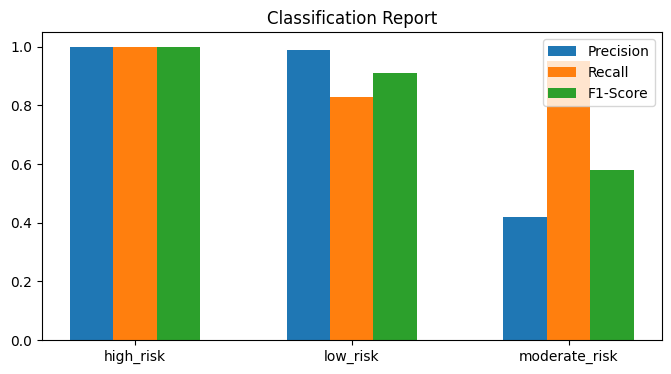

In [7]:
# 柱状图(Bar Chart):分别为precision, recall, f1-score绘制柱状图,不同类别用不同颜色表示。
import matplotlib.pyplot as plt
import numpy as np

categories = ['high_risk', 'low_risk', 'moderate_risk']
precision = [1.00, 0.99, 0.42]
recall = [1.00, 0.83, 0.95]
f1_score = [1.00, 0.91, 0.58]

fig, ax = plt.subplots(figsize=(8, 4))
x = np.arange(len(categories))
width = 0.2

ax.bar(x - width, precision, width, label='Precision')
ax.bar(x, recall, width, label='Recall')
ax.bar(x + width, f1_score, width, label='F1-Score')

ax.set_title('Classification Report')
ax.set_xticks(x)
ax.set_xticklabels(categories)
ax.legend()

plt.show()

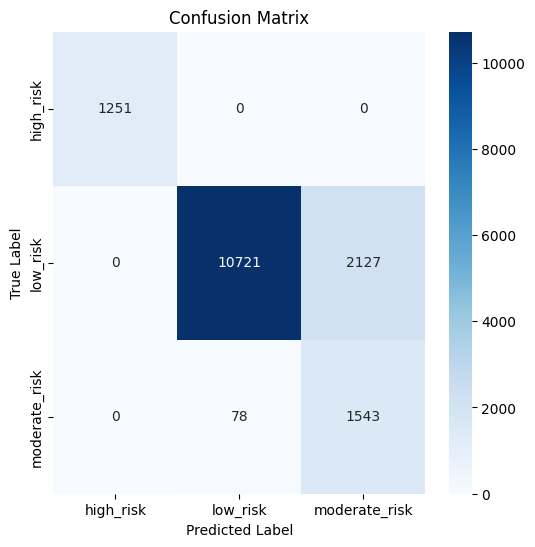

In [8]:
#混淆矩阵(Confusion Matrix):使用热力图展示真实类别与预测类别的样本数量分布。
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_test, y_pred)

fig, ax = plt.subplots(figsize=(6, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d',
            xticklabels=categories, yticklabels=categories)
ax.set_title('Confusion Matrix')
ax.set_xlabel('Predicted Label')
ax.set_ylabel('True Label')

plt.show()

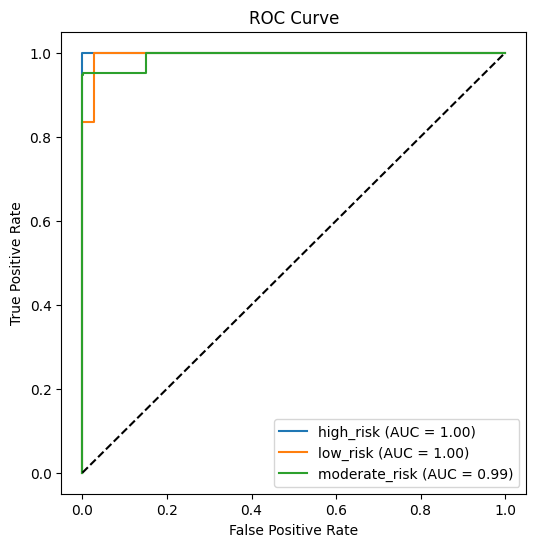

In [9]:
#ROC曲线(Receiver Operating Characteristic Curve):绘制每个类别的ROC曲线,展示在不同阈值下的假正例率(FPR)和真正例率(TPR)的变化。
from sklearn.metrics import roc_curve, auc

y_prob = gnb.predict_proba(X_test)

fig, ax = plt.subplots(figsize=(6, 6))
for i, category in enumerate(categories):
    fpr, tpr, _ = roc_curve(y_test == category, y_prob[:, i])
    roc_auc = auc(fpr, tpr)
    ax.plot(fpr, tpr, label=f'{category} (AUC = {roc_auc:.2f})')

ax.plot([0, 1], [0, 1], 'k--')
ax.set_title('ROC Curve')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.legend(loc='lower right')

plt.show()